In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [2]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Lambda(lambda x: x.view(-1))])

train_dataset = torchvision.datasets.MNIST(root = './data', train= True, transform=transform, download=True)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True)

In [3]:
class UnderCompleteAutoencoders(nn.Module):
    def __init__(self, input_dim = 784, latent_dim=2):
        super(UnderCompleteAutoencoders, self).__init__()
        
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, latent_dim)
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim,128),
            nn.ReLU(),
            nn.Linear(128,input_dim),
            nn.Sigmoid()
        )
    def forward(self,x):
        z = self.encoder(x)
        x_hat = self.decoder(z)
        return x_hat, z 

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = UnderCompleteAutoencoders().to(device)

In [4]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 10
for epoch in range(num_epochs):
    total_loss = 0
    for data, _ in train_loader:
        data = data.to(device)
        
        optimizer.zero_grad()
        outputs, _ = model(data)
        loss = criterion(outputs, data)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss/len(train_loader):.4f}')
        

Epoch [1/10], Loss: 0.0625
Epoch [2/10], Loss: 0.0506
Epoch [3/10], Loss: 0.0487
Epoch [4/10], Loss: 0.0475
Epoch [5/10], Loss: 0.0466
Epoch [6/10], Loss: 0.0459
Epoch [7/10], Loss: 0.0455
Epoch [8/10], Loss: 0.0450
Epoch [9/10], Loss: 0.0447
Epoch [10/10], Loss: 0.0444


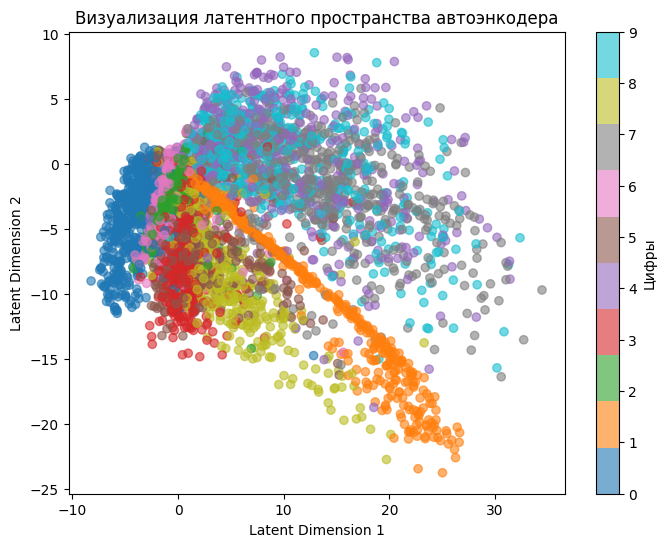

In [5]:
def visualize_latent_space(model, dataloader, device, num_samples=5000):
    model.eval()
    all_latents = []
    all_labels = []

    with torch.no_grad():
        for data, labels in dataloader:
            data = data.to(device)
            _, latents = model(data)
            all_latents.append(latents.cpu().numpy())
            all_labels.append(labels.numpy())

            if len(all_latents) * len(data) >= num_samples:
                break

    all_latents = np.concatenate(all_latents, axis=0)
    all_labels = np.concatenate(all_labels, axis=0)

    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(all_latents[:, 0], all_latents[:, 1], c=all_labels, cmap='tab10', alpha=0.6)
    plt.colorbar(scatter, label="Цифры")
    plt.xlabel("Latent Dimension 1")
    plt.ylabel("Latent Dimension 2")
    plt.title("Визуализация латентного пространства автоэнкодера")
    plt.show()

# Вызов функции
visualize_latent_space(model, train_loader, device)
